In [1]:
import sys

print(f"Interpreter dir: {sys.executable}")
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("../")

print(f"Working dir: {os.getcwd()}")
%load_ext autoreload
%autoreload 2

Interpreter dir: /Users/jsg/Documents/Stor/PdM_mockup/.venv_storpdm/bin/python3.7
Working dir: /Users/jsg/Documents/Stor/PdM_mockup


In [62]:
# General
from pathlib import Path

# Data & modeling
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import lightgbm as lgb
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.neural_network import MLPRegressor


# PLotting
import matplotlib.pyplot as plt
import plotly

# plotly.offline.init_notebook_mode(connected=True)

# Custom package
from storpdm import DATA_PATH
from storpdm.make_dataset import download_dataset, import_dataset
from storpdm.visualize import (
    visualise_sensor_correlation_all_engine,
    visualise_sensor_data_distribution,
    plot_time_history_all_engines,
)
from storpdm.build_features import (
    find_correlated_data,
    list_correlated_data,
    find_time_independent_columns,
    add_calculated_rul,
    prepare_training_data,
)
from storpdm.train_model import EstimatorSelectionHelper

---

# Problem definition and experimental scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine, i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series: the fault grows in magnitude until system failure.

The **aim** is to model and predict the Remaining Time of Failure (RUL) as accurately as possible. In a practical setup, such model can be used for:

- root-cause analysos
- Real-time monitoring 


---

# Download raw data, unzip and load to memory

In [20]:
## Run the download function only once
if len(list(Path('data/raw').glob('train_*.txt'))) == 4:
    print('Raw data has been downloaded')
else:
    download_dataset()


Raw data has been downloaded


In [21]:
# Load datasets
df_rul, df_train, df_test = import_dataset(filename="FD001")
display(df_train)

id  cycle     op1     op2    op3  FanInletTemp  LPCOutletTemp  \
0        1      1 -0.0007 -0.0004  100.0        518.67         641.82   
1        1      2  0.0019 -0.0003  100.0        518.67         642.15   
2        1      3 -0.0043  0.0003  100.0        518.67         642.35   
3        1      4  0.0007  0.0000  100.0        518.67         642.35   
4        1      5 -0.0019 -0.0002  100.0        518.67         642.37   
...    ...    ...     ...     ...    ...           ...            ...   
20626  100    196 -0.0004 -0.0003  100.0        518.67         643.49   
20627  100    197 -0.0016 -0.0005  100.0        518.67         643.54   
20628  100    198  0.0004  0.0000  100.0        518.67         643.42   
20629  100    199 -0.0011  0.0003  100.0        518.67         643.23   
20630  100    200 -0.0032 -0.0005  100.0        518.67         643.85   

       HPCOutletTemp  LPTOutletTemp  FanInletPres  BypassDuctPres  \
0            1589.70        1400.60         14.62           21.61   
1            1591.82        1403.14         14.62           21.61   
2            1587.99        1404.20         14.62           21.61   
3            1582.79        1401.87         14.62           21.61   
4            1582.85        1406.22         14.62           21.61   
...              ...            ...           ...             ...   
20626        1597.98        1428.63         14.62           21.61   
20627        1604.50        1433.58         14.62           21.61   
20628        1602.46        1428.18         14.62           21.61   
20629        1605.26        1426.53         14.62           21.61   
20630        1600.38        1432.14         14.62           21.61   

       TotalHPCOutletPres  PhysFanSpeed  PhysCoreSpeed  EnginePresRatio  \
0                  554.36       2388.06        9046.19              1.3   
1                  553.75       2388.04        9044.07              1.3   
2                  554.26       2388.08        9052.94              1.3   
3                  554.45       2388.11        9049.48              1.3   
4                  554.00       2388.06        9055.15              1.3   
...                   ...           ...            ...              ...   
20626              551.43       2388.19        9065.52              1.3   
20627              550.86       2388.23        9065.11              1.3   
20628              550.94       2388.24        9065.90              1.3   
20629              550.68       2388.25        9073.72              1.3   
20630              550.79       2388.26        9061.48              1.3   

       StaticHPCOutletPres  FuelFlowRatio  CorrFanSpeed  CorrCoreSpeed  \
0                    47.47         521.66       2388.02        8138.62   
1                    47.49         522.28       2388.07        8131.49   
2                    47.27         522.42       2388.03        8133.23   
3                    47.13         522.86       2388.08        8133.83   
4                    47.28         522.19       2388.04        8133.80   
...                    ...            ...           ...            ...   
20626                48.07         519.49       2388.26        8137.60   
20627                48.04         519.68       2388.22        8136.50   
20628                48.09         520.01       2388.24        8141.05   
20629                48.39         519.67       2388.23        8139.29   
20630                48.20         519.30       2388.26        8137.33   

       BypassRatio  BurnerFuelAirRatio  BleedEnthalpy  DemandFanSpeed  \
0           8.4195                0.03            392            2388   
1           8.4318                0.03            392            2388   
2           8.4178                0.03            390            2388   
3           8.3682                0.03            392            2388   
4           8.4294                0.03            393            2388   
...            ...                 ...            ...             ...   
2

# Pre-process data and visualize

- Remove correlated sensors
- Constant data with time
- ...

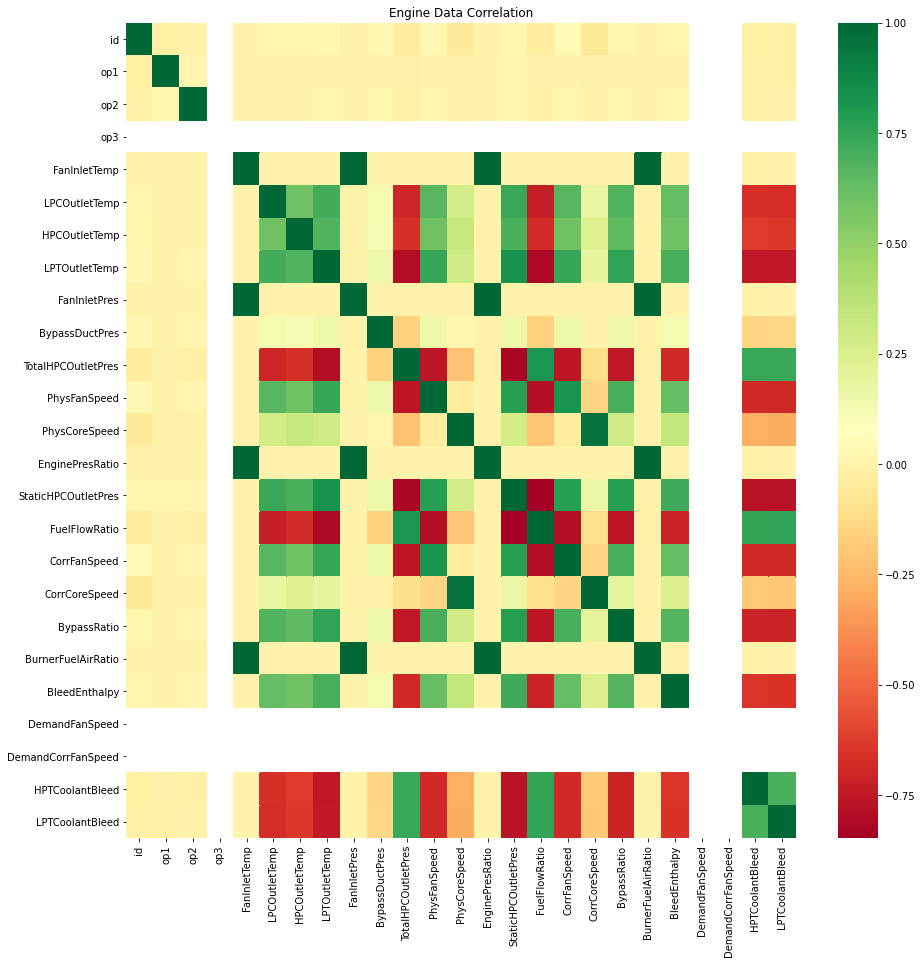

In [22]:
plt.figure(figsize=(15, 15))
visualise_sensor_correlation_all_engine(df_train)

In [23]:
# Reduce / Eliminate highly-correlated sensors.
correlation_threshold = 0.95
correlated_data = find_correlated_data(df_train, correlation_threshold)
columns_to_be_removed = list_correlated_data(correlated_data)

In [24]:
print(f"Removing {columns_to_be_removed} from columns")
df_train_proc = df_train.drop(columns_to_be_removed, axis=1)

Removing ['FanInletPres', 'EnginePresRatio', 'BurnerFuelAirRatio', 'CorrCoreSpeed'] from columns


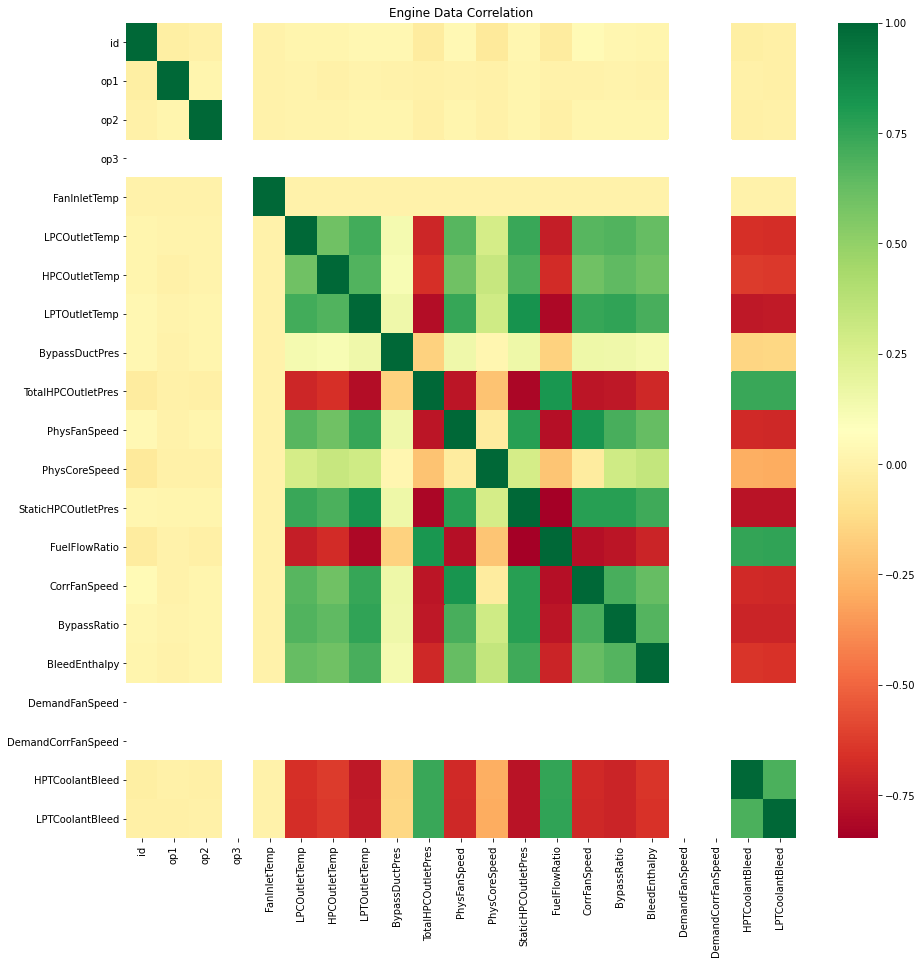

In [25]:
# Visualise correlations, extreme ones should have been removed
plt.figure(figsize=(15, 15))
visualise_sensor_correlation_all_engine(df_train_proc)

/Users/jsg/Documents/Stor/PdM_mockup/.venv_storpdm/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/jsg/Documents/Stor/PdM_mockup/.venv_storpdm/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/jsg/Documents/Stor/PdM_mockup/.venv_storpdm/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/jsg/Documents/Stor/PdM_mockup/.venv_storpdm/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 1080x1080 with 0 Axes>

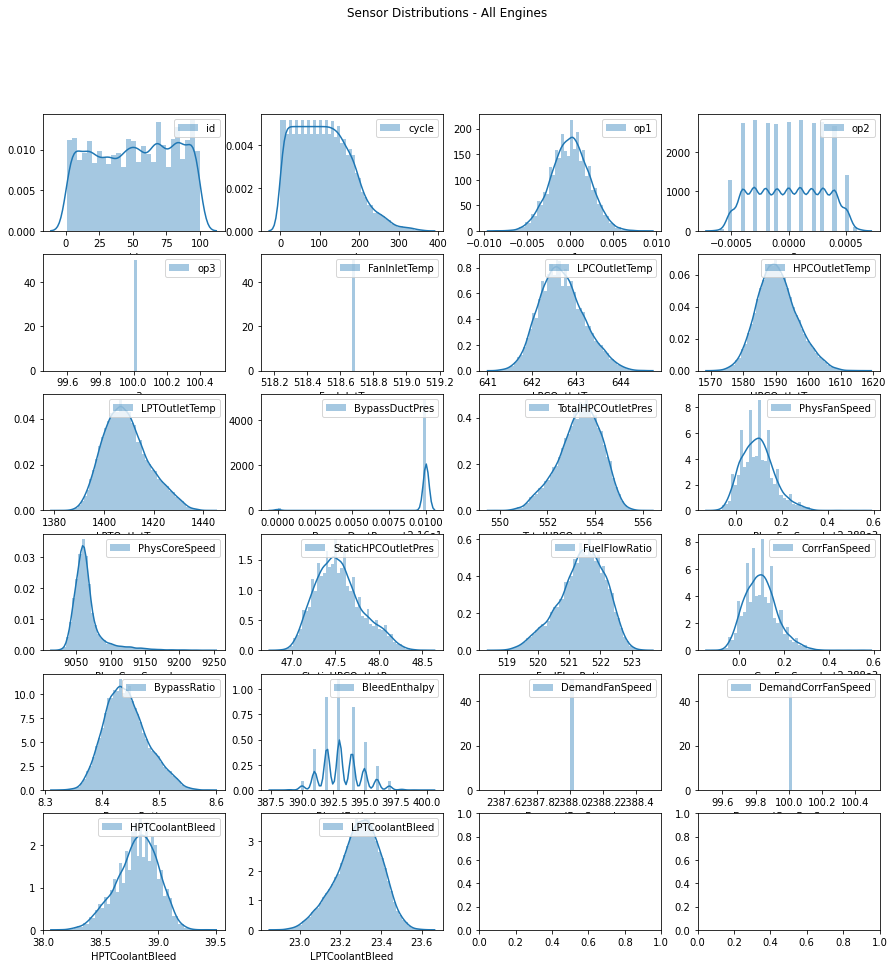

In [26]:
plt.figure(figsize=(15, 15))
fig = visualise_sensor_data_distribution(df_train_proc)

In [27]:
# Remove data that does not change with time.
time_independent_columns = find_time_independent_columns(df_train_proc)
print(f"Removing constant columns: {time_independent_columns}")

df_train_proc2 = df_train_proc.drop(time_independent_columns, axis=1)
display(df_train_proc2)

Removing constant columns: ['op3', 'FanInletTemp', 'BypassDuctPres', 'PhysFanSpeed', 'CorrFanSpeed', 'DemandFanSpeed', 'DemandCorrFanSpeed']


id  cycle     op1     op2  LPCOutletTemp  HPCOutletTemp  \
0        1      1 -0.0007 -0.0004         641.82        1589.70   
1        1      2  0.0019 -0.0003         642.15        1591.82   
2        1      3 -0.0043  0.0003         642.35        1587.99   
3        1      4  0.0007  0.0000         642.35        1582.79   
4        1      5 -0.0019 -0.0002         642.37        1582.85   
...    ...    ...     ...     ...            ...            ...   
20626  100    196 -0.0004 -0.0003         643.49        1597.98   
20627  100    197 -0.0016 -0.0005         643.54        1604.50   
20628  100    198  0.0004  0.0000         643.42        1602.46   
20629  100    199 -0.0011  0.0003         643.23        1605.26   
20630  100    200 -0.0032 -0.0005         643.85        1600.38   

       LPTOutletTemp  TotalHPCOutletPres  PhysCoreSpeed  StaticHPCOutletPres  \
0            1400.60              554.36        9046.19                47.47   
1            1403.14              553.75        9044.07                47.49   
2            1404.20              554.26        9052.94                47.27   
3            1401.87              554.45        9049.48                47.13   
4            1406.22              554.00        9055.15                47.28   
...              ...                 ...            ...                  ...   
20626        1428.63              551.43        9065.52                48.07   
20627        1433.58              550.86        9065.11                48.04   
20628        1428.18              550.94        9065.90                48.09   
20629        1426.53              550.68        9073.72                48.39   
20630        1432.14              550.79        9061.48                48.20   

       FuelFlowRatio  BypassRatio  BleedEnthalpy  HPTCoolantBleed  \
0             521.66       8.4195            392            39.06   
1             522.28       8.4318            392            39.00   
2             522.42       8.4178            390            38.95   
3             522.86       8.3682            392            38.88   
4             522.19       8.4294            393            38.90   
...              ...          ...            ...              ...   
20626         519.49       8.4956            397            38.49   
20627         519.68       8.5139            395            38.30   
20628         520.01       8.5646            398            38.44   
20629         519.67       8.5389            395            38.29   
20630         519.30       8.5036            396            38.37   

       LPTCoolantBleed  
0              23.4190  
1              23.4236  
2              23.3442  
3              23.3739  
4              23.4044  
...                ...  
20626          22.9735  
20627          23.1594  
20628          22.9333  
20629          23.0640  
20630          23.0522  

[20631 rows x 15 columns]

<Figure size 2520x1224 with 0 Axes>

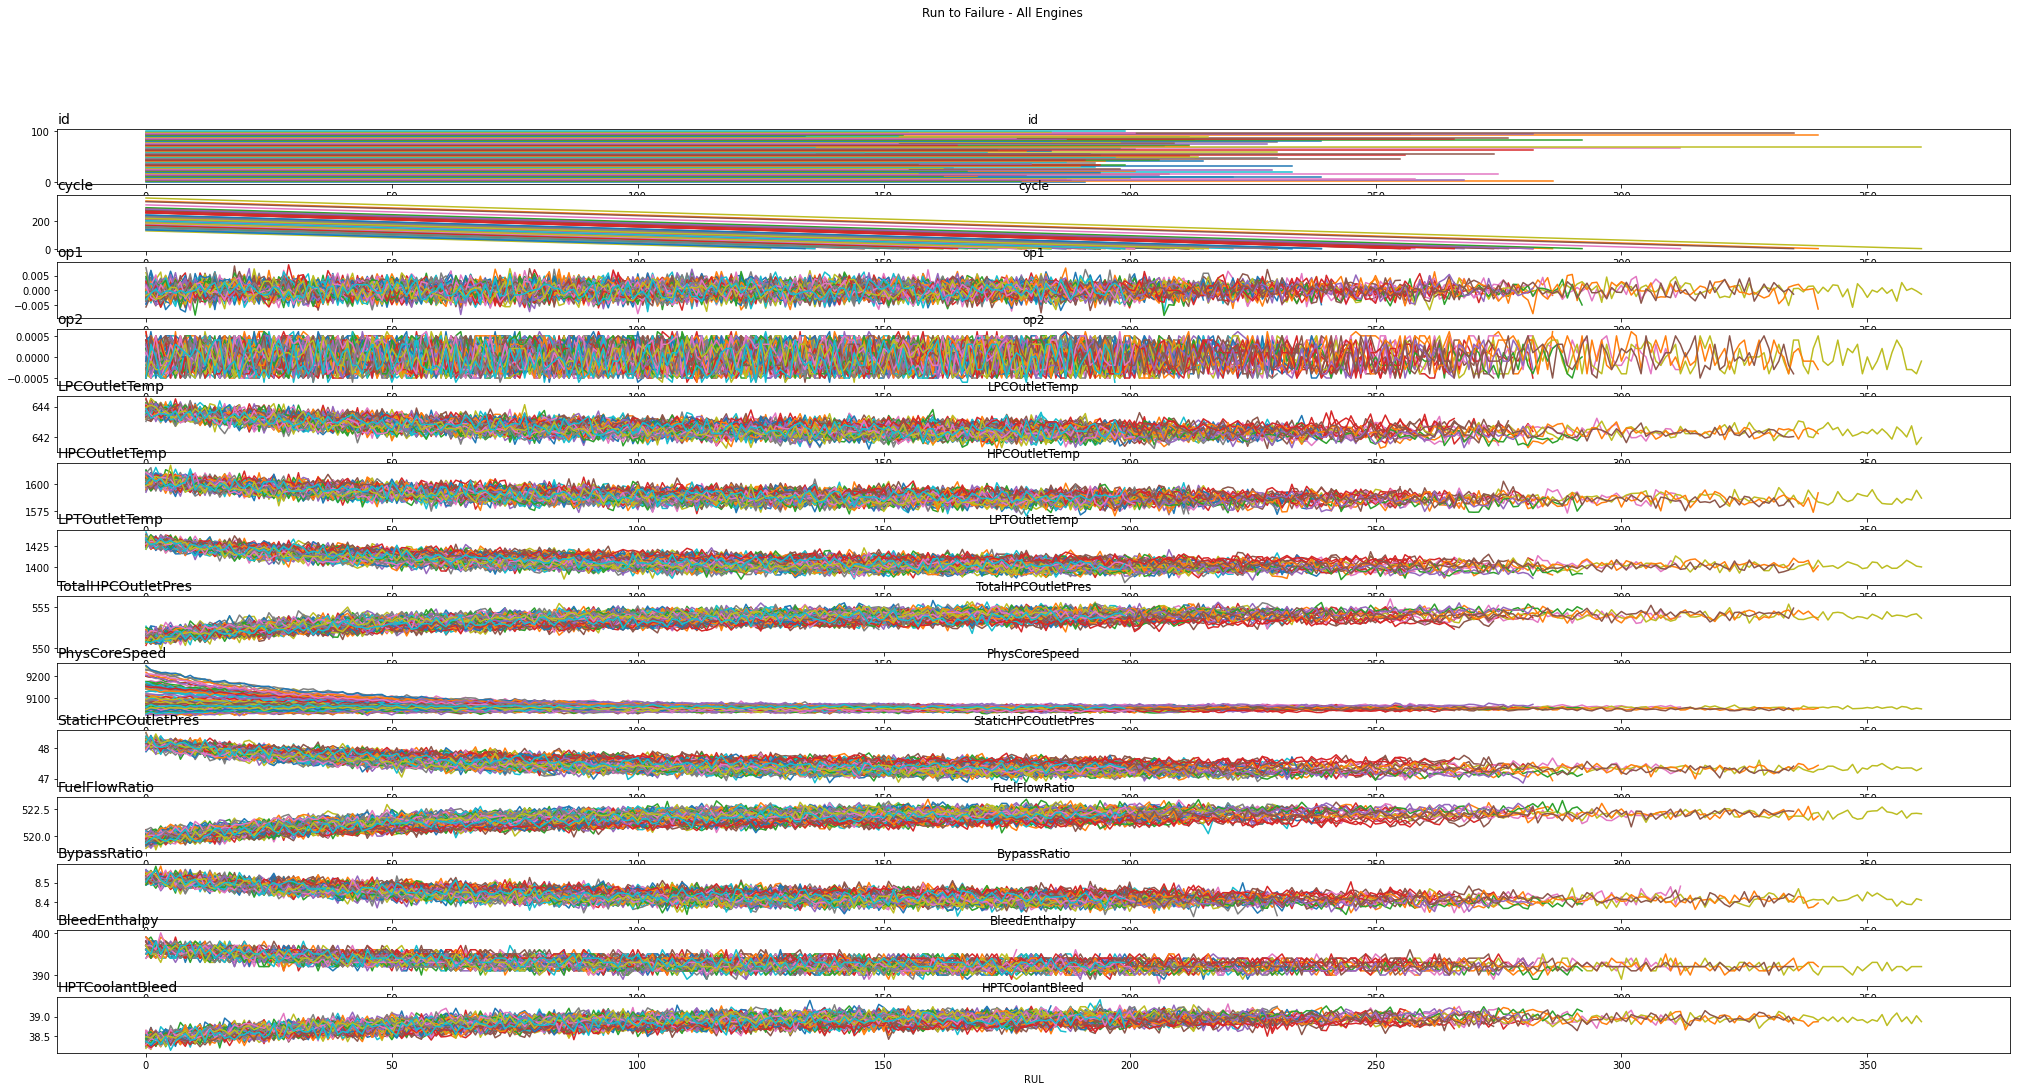

In [28]:
# Add Remaining Useful Life (RUL) to dataset.
df_train_proc2 = add_calculated_rul(df_train_proc2)

# Visualise sensor behaviour against RUL.
plt.figure(figsize=(35, 17))
fig = plot_time_history_all_engines(df_train_proc2)

In [12]:
from storpdm.visualize import interactive_rul_series
fig = interactive_rul_series(df_train_proc2, filename='reports/series.html')

# Find best model and train

We perform a comparison of 3 different models with several combinations of hyperparameters and automatically select the best one

In [13]:
df_train_proc2

id  cycle     op1     op2  LPCOutletTemp  HPCOutletTemp  \
0        1      1 -0.0007 -0.0004         641.82        1589.70   
1        1      2  0.0019 -0.0003         642.15        1591.82   
2        1      3 -0.0043  0.0003         642.35        1587.99   
3        1      4  0.0007  0.0000         642.35        1582.79   
4        1      5 -0.0019 -0.0002         642.37        1582.85   
...    ...    ...     ...     ...            ...            ...   
20626  100    196 -0.0004 -0.0003         643.49        1597.98   
20627  100    197 -0.0016 -0.0005         643.54        1604.50   
20628  100    198  0.0004  0.0000         643.42        1602.46   
20629  100    199 -0.0011  0.0003         643.23        1605.26   
20630  100    200 -0.0032 -0.0005         643.85        1600.38   

       LPTOutletTemp  TotalHPCOutletPres  PhysCoreSpeed  StaticHPCOutletPres  \
0            1400.60              554.36        9046.19                47.47   
1            1403.14              553.75        9044.07                47.49   
2            1404.20              554.26        9052.94                47.27   
3            1401.87              554.45        9049.48                47.13   
4            1406.22              554.00        9055.15                47.28   
...              ...                 ...            ...                  ...   
20626        1428.63              551.43        9065.52                48.07   
20627        1433.58              550.86        9065.11                48.04   
20628        1428.18              550.94        9065.90                48.09   
20629        1426.53              550.68        9073.72                48.39   
20630        1432.14              550.79        9061.48                48.20   

       FuelFlowRatio  BypassRatio  BleedEnthalpy  HPTCoolantBleed  \
0             521.66       8.4195            392            39.06   
1             522.28       8.4318            392            39.00   
2             522.42       8.4178            390            38.95   
3             522.86       8.3682            392            38.88   
4             522.19       8.4294            393            38.90   
...              ...          ...            ...              ...   
20626         519.49       8.4956            397            38.49   
20627         519.68       8.5139            395            38.30   
20628         520.01       8.5646            398            38.44   
20629         519.67       8.5389            395            38.29   
20630         519.30       8.5036            396            38.37   

       LPTCoolantBleed  RUL  
0              23.4190  191  
1              23.4236  190  
2              23.3442  189  
3              23.3739  188  
4              23.4044  187  
...                ...  ...  
20626          22.9735    4  
20627          23.1594    3  
20628          22.9333    2  
20629          23.0640    1  
20630          23.0522    0  

[20631 rows x 16 columns]

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler

# Define models
models = {
    #"rf": RandomForestRegressor(), # 3 minutes
    "lgb": lgb.LGBMRegressor(),
    "linear": Ridge(normalize = True),
    "mlp": Pipeline([("std",MinMaxScaler()),
                       ("m1",MLPRegressor(early_stopping=True))])
}

# Define hyperparam search space
params = {
    #"rf": {"n_estimators": [100, 500]},
    "lgb": {
        "n_estimators": [100, 500],
        "learning_rate": [0.005, 0.01],
        "max_depth":[5,10,15,20]
    },
    "mlp": {
        "m1__hidden_layer_sizes": [(128),(64, 32)],
        "m1__learning_rate_init": [0.001,0.005,0.01],
    },
    "linear": {},
}

In [15]:
X_train, X_test, y_train, y_test = prepare_training_data(
    df=df_train_proc2, target_col="RUL", discard_cols="id"
)

In [16]:
%%time
estim_grid = EstimatorSelectionHelper(models, params)
estim_grid.fit(X_train, y_train, scoring="neg_root_mean_squared_error", n_jobs=2, cv=None)

Running GridSearchCV for lgb.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.9s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:   35.3s finished


Running GridSearchCV for linear.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished


Running GridSearchCV for mlp.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.9min finished


CPU times: user 40 s, sys: 5.6 s, total: 45.6 s
Wall time: 2min 42s


In [17]:
estim_grid.score_summary()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
9        0.867711      0.073189         0.051284        0.003321   
11       1.038426      0.044337         0.052906        0.004495   
13       1.011044      0.040755         0.046719        0.000821   
15       1.054882      0.138156         0.051790        0.006336   
1        9.110094      0.582487         0.009723        0.000482   
5        4.308062      0.718782         0.008635        0.002287   
4        5.394266      0.865764         0.007359        0.000313   
2        6.271799      1.198739         0.009277        0.000304   
3        9.306653      2.792825         0.008085        0.000716   
1        0.863386      0.070947         0.038427        0.001801   
3        1.284920      0.126337         0.051487        0.005600   
7        1.272287      0.077552         0.053721        0.010577   
5        1.268563      0.082005         0.042345        0.001168   
0       11.647052      3.299791         0.009955        0.000590   
0        0.009876      0.000466         0.002986        0.000063   
14       0.262388      0.019035         0.012205        0.000639   
10       0.327531      0.074700         0.012049        0.000486   
12       0.262739      0.013671         0.011845        0.000429   
8        0.204102      0.008042         0.011772        0.000912   
6        0.282174      0.009774         0.011414        0.000373   
2        0.254057      0.025800         0.010337        0.000404   
4        0.269255      0.017783         0.011334        0.000509   
0        0.458780      0.256438         0.011602        0.002128   

   param_learning_rate param_max_depth param_n_estimators  \
9                 0.01               5                500   
11                0.01              10                500   
13                0.01              15                500   
15                0.01              20                500   
1                  NaN             NaN                NaN   
5                  NaN             NaN                NaN   
4                  NaN             NaN                NaN   
2                  NaN             NaN                NaN   
3                  NaN             NaN                NaN   
1                0.005               5                500   
3                0.005              10                500   
7                0.005              20                500   
5                0.005              15                500   
0                  NaN             NaN                NaN   
0                  NaN             NaN                NaN   
14                0.01              20                100   
10                0.01              10                100   
12                0.01              15                100   
8                 0.01               5                100   
6                0.005              20                100   
2                0.005              10                100   
4                0.005              15                100   
0                0.005               5                100   

                                               params  split0_test_score  \
9   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...         -36.434756   
11  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...         -36.376685   
13  {'learning_rate': 0.01, 'max_depth': 15, 'n_es...         -36.372964   
15  {'learning_rate': 0.01, 'max_depth': 20, 'n_es...         -36.377626   
1   {'m1__hidden_layer_sizes': 128, 'm1__learning_...         -36.315658   
5   {'m1__hidden_layer_sizes': (64, 32), 'm1__lear...         -36.210221   
4   {'m1__hidden_layer_sizes': (64, 32), 'm1__lear...         -36.340776   
2   {'m1__hidden_layer_sizes': 128, 'm1__learning_...         -36.266409   
3   {'m1__hidden_layer_sizes': (64, 32), 'm1__lear...         -36.714542   
1   {'learning_rate': 0.005, 'max_depth': 5, 'n_es...         -36.815716   
3   {'learning_rate': 0.005, 'max_depth': 10, 'n_e...         -36.8342

In [18]:
model = estim_grid.best_model
model

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=500)

In [19]:
y_test_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Random Forest Regression test MAE: {mae:.3f}")
print(f"Random Forest Regression test RMSE: {rmse:.3f}")


Random Forest Regression test MAE: 25.106
Random Forest Regression test RMSE: 35.570


In [20]:
# Predictions on "test" dataset # TODO
# Not so interesting for this exercise

# Model diagnostics and interpretation

In [21]:
df_plot = pd.DataFrame({"y_test":y_test, "y_test_pred": y_test_pred})
df_plot = df_plot.sort_values('y_test')

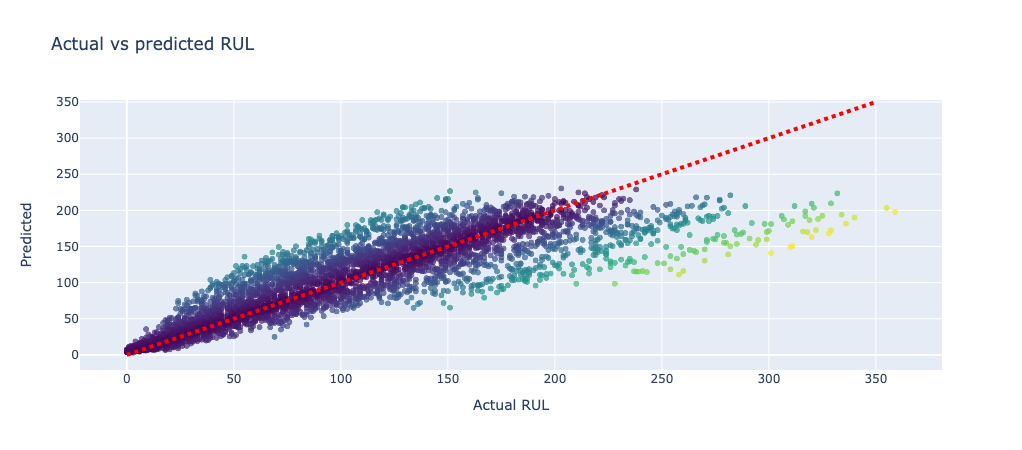

In [22]:
# TODO: plot predicted RUL vs actual RUL
# Order by RUL, should be a nice graph
import numpy as np
import plotly.graph_objects as go

# Create traces
fig = go.Figure()
fig.add_trace(
    go.Scattergl(
        x=df_plot["y_test"],
        y=df_plot["y_test_pred"],
        mode="markers",
        marker=dict(
            color=np.abs(df_plot["y_test"] - df_plot["y_test_pred"]),
            colorscale="Viridis",
            line_width=0,
            opacity=0.7,
            size=6,
        ),
        name="lines",
    )
)
fig.add_shape(type="line", x0=0, y0=0, x1=350, y1=350, line=dict(width=4, dash="dot",color='red'))
fig.update_layout(
    title="Actual vs predicted RUL",
    xaxis_title="Actual RUL",
    yaxis_title="Predicted"
)
fig.show()

In [23]:
# TODO: Shap feature importance ---> FIXME
import shap

explainer = shap.KernelExplainer(model.predict, data=X_train.sample(100))

In [ ]:
X_sample = X_train.sample(100)
shap_values = explainer.shap_values(X_sample, l1_reg = 'num_features(100)')

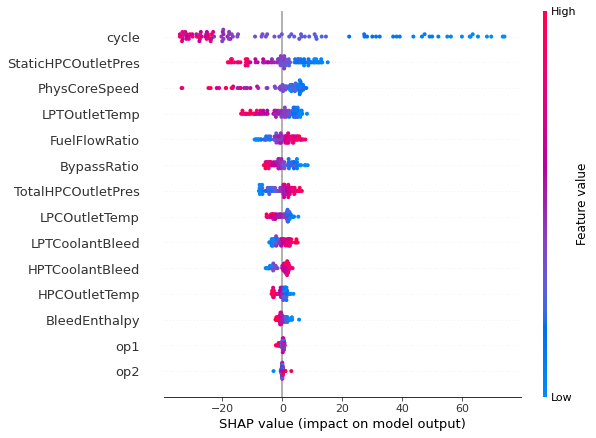

In [25]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sample)

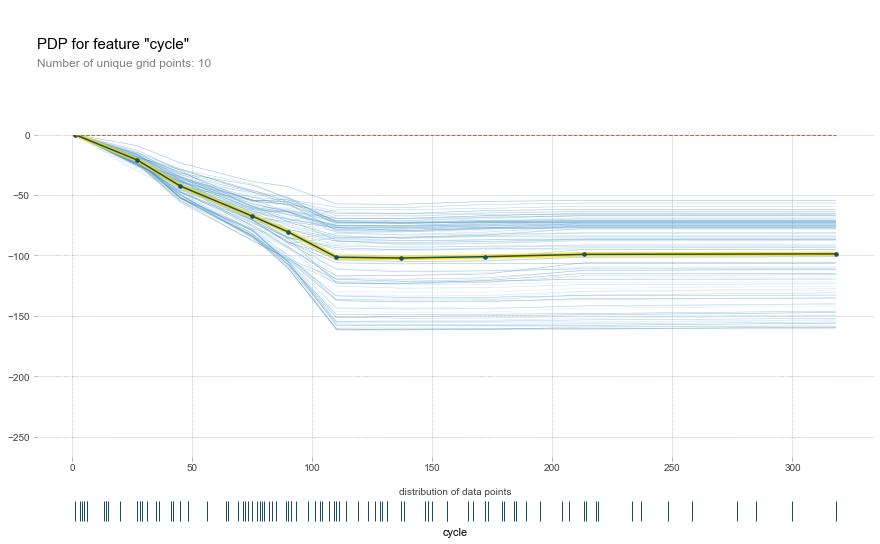

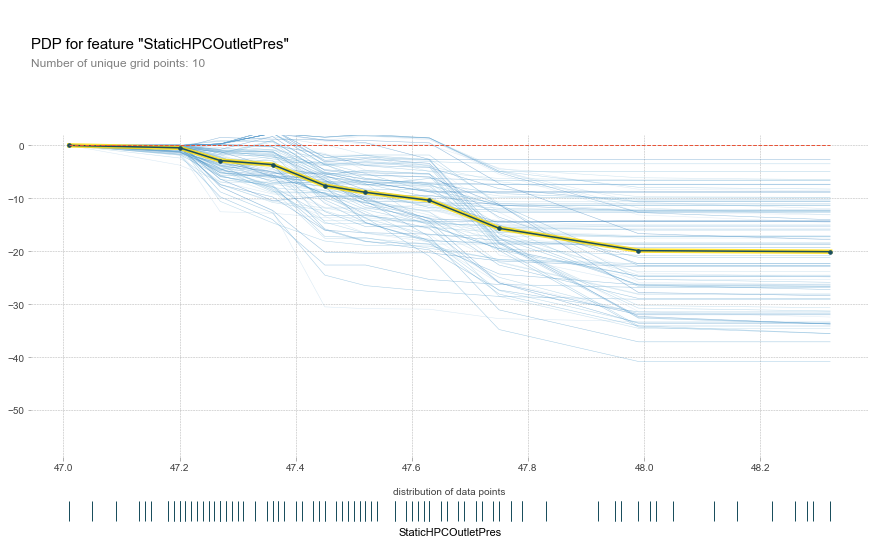

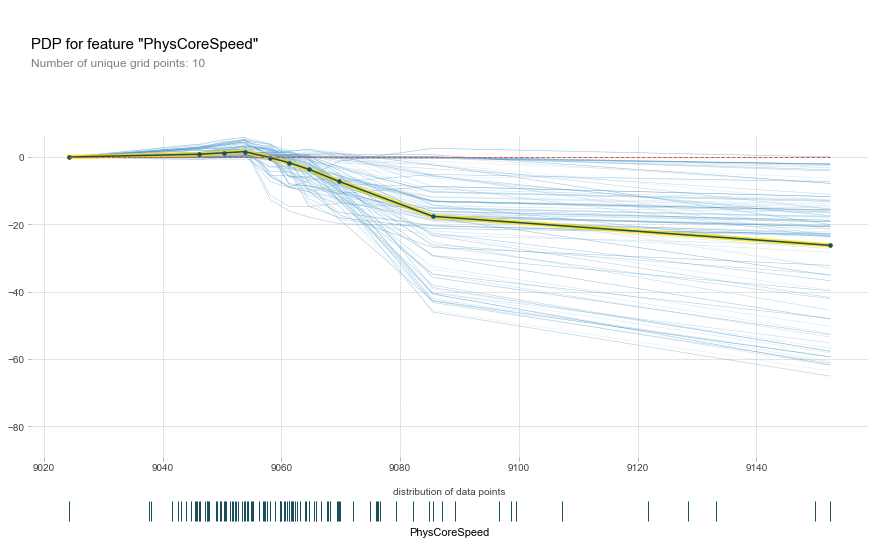

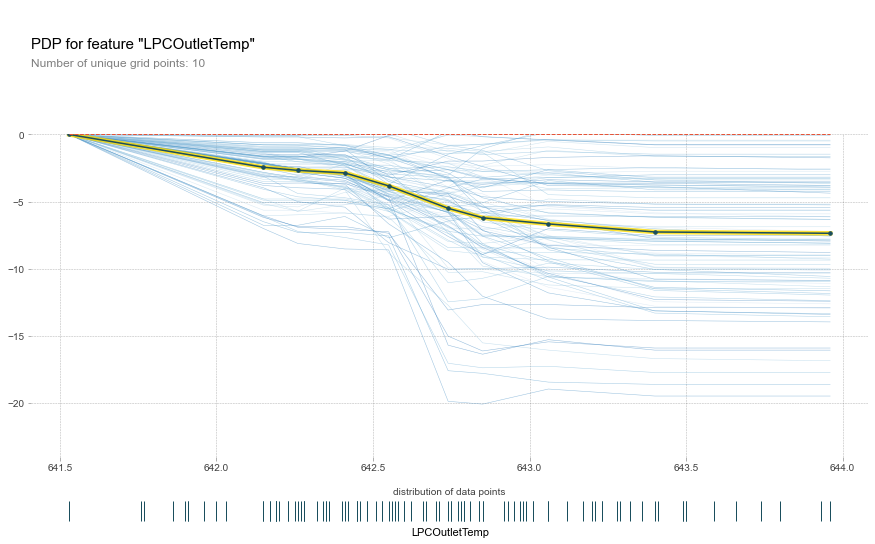

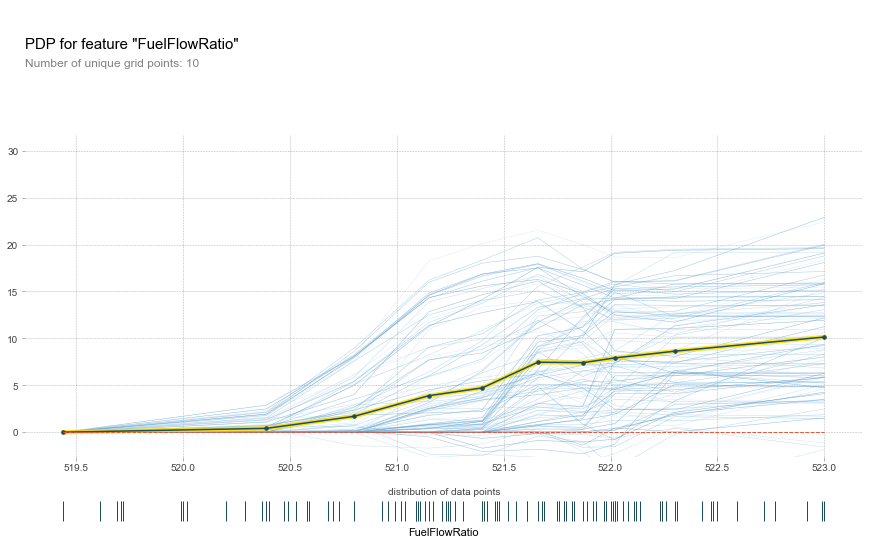

In [28]:
from pdpbox import pdp, get_dataset, info_plots

features = ['cycle','StaticHPCOutletPres','PhysCoreSpeed','LPCOutletTemp','FuelFlowRatio']

for f in features:
    
    pdp_goals = pdp.pdp_isolate(model = model, 
                                dataset = X_sample, 
                                model_features = X_train.columns,
                                feature = f)
    pdp.pdp_plot(pdp_goals, f, x_quantile=False,  plot_pts_dist=True, plot_lines=True,center=True)

# Fit a classification model: will the engine fail in less than 10 cycles? With what probability?

In [29]:
cycle_threshold = 10
df_train_proc2['RUL_thres'] = np.where(df_train_proc2['RUL'] <= cycle_threshold, 1, 0)

In [34]:
from sklearn.neural_network import MLPClassifier 
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# Define models
models = {
    #"rf": RandomForestRegressor(), # 3 minutes
    "lgb": lgb.LGBMClassifier(),
    "logistic": LogisticRegression(max_iter=300),
    "mlp": Pipeline([("std",MinMaxScaler()),
                       ("m1",MLPClassifier(early_stopping=True))])
}

# Define hyperparam search space
params = {
    #"rf": {"n_estimators": [100, 500]},
    "lgb": {
        "n_estimators": [100, 500],
        "learning_rate": [0.005, 0.01],
        "max_depth":[5,10,15,20]
    },
    "mlp": {
        "m1__hidden_layer_sizes": [(128),(64, 32)],
        "m1__learning_rate_init": [0.001,0.005,0.01],
    },
    "logistic": {},
}

In [45]:
X_train, X_test, y_train, y_test = prepare_training_data(
    df=df_train_proc2, target_col="RUL_thres", discard_cols=["id","RUL"]
)

In [52]:
%%time
estim_grid = EstimatorSelectionHelper(models, params)
estim_grid.fit(X_train, y_train, scoring="f1", n_jobs=2, cv=None)

Running GridSearchCV for lgb.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.5s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:   24.2s finished


Running GridSearchCV for logistic.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished
/Users/jsg/Documents/Stor/PdM_mockup/.venv_storpdm/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for mlp.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   30.8s finished


CPU times: user 12.9 s, sys: 1.04 s, total: 14 s
Wall time: 58.4 s


In [53]:
estim_grid.score_summary().head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
15       0.777760      0.043880         0.030262        0.002142   
9        0.598554      0.009007         0.036904        0.001058   
13       0.824516      0.043431         0.030264        0.000957   
11       0.844884      0.087846         0.042020        0.015925   
7        0.891208      0.069792         0.028650        0.000402   

   param_learning_rate param_max_depth param_n_estimators  \
15                0.01              20                500   
9                 0.01               5                500   
13                0.01              15                500   
11                0.01              10                500   
7                0.005              20                500   

                                               params  split0_test_score  \
15  {'learning_rate': 0.01, 'max_depth': 20, 'n_es...           0.842105   
9   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...           0.849711   
13  {'learning_rate': 0.01, 'max_depth': 15, 'n_es...           0.835294   
11  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...           0.835294   
7   {'learning_rate': 0.005, 'max_depth': 20, 'n_e...           0.822823   

    split1_test_score  split2_test_score  split3_test_score  \
15           0.836158           0.820809           0.807910   
9            0.828571           0.821530           0.800000   
13           0.825843           0.815029           0.804533   
11           0.821530           0.811594           0.801136   
7            0.825581           0.819767           0.797654   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
15           0.821114         0.825619        0.012165                1   
9            0.816327         0.823228        0.016248                2   
13           0.810651         0.818270        0.010995                3   
11           0.814159         0.816743        0.011347                4   
7            0.796353         0.812436        0.012741                5   

    split0_train_score  split1_train_score  split2_train_score  \
15            0.993612            0.990774            0.994318   
9             0.923843            0.923735            0.930466   
13            0.992193            0.990071            0.995025   
11            0.985117            0.984353            0.991465   
7             0.948958            0.951833            0.957401   

    split3_train_score  split4_train_score  mean_train_score  std_train_score  \
15            0.995733            0.995733          0.994034         0.001825   
9             0.932384            0.927350          0.927556         0.003470   
13            0.995018            0.996441          0.993750         0.002299   
11            0.985755            0.988604          0.987059         0.002630   
7             0.954644            0.954155          0.953398         0.002839   

   model param_m1__hidden_layer_sizes param_m1__learning_rate_init  
15   lgb                          NaN                          NaN  
9    lgb                          NaN                          NaN  
13   lgb                          NaN                          NaN  
11   lgb                          NaN                          NaN  
7    lgb                          NaN                          NaN

In [60]:
estim_grid.best_model


LGBMClassifier(learning_rate=0.01, max_depth=20, n_estimators=500)

In [63]:

model = estim_grid.best_model
y_test_pred = model.predict(X_test)
f1 = f1_score(y_test, y_test_pred)
print(f"F1 score test: {f1:.3f}")

F1 score test: 0.831


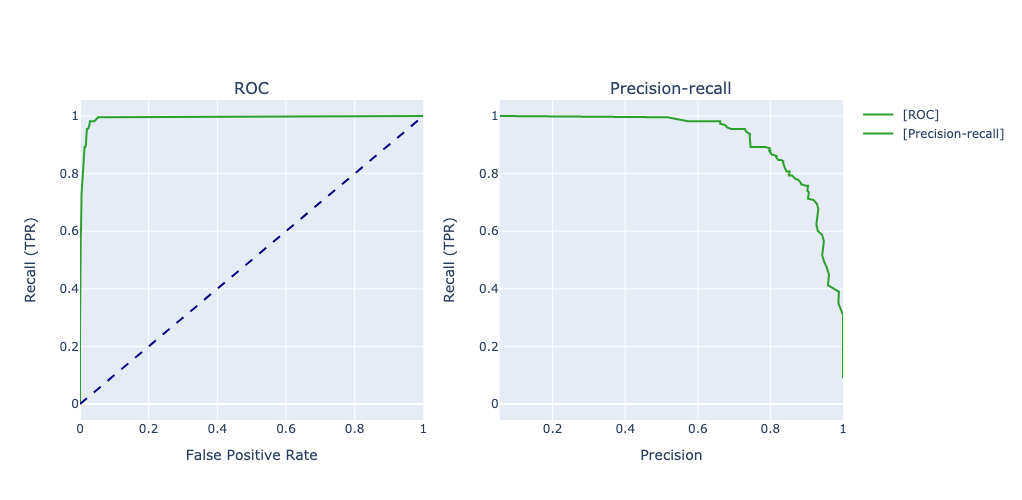

In [87]:
from storpdm.utils import metrics_threshold
from storpdm.build_features import prepare_training_data
from storpdm.visualize import display_roc_pr

y_score = model.predict_proba(X_test)
metrics = metrics_threshold(y_score[:,1], y_test)

display_roc_pr(precision = metrics['prec'],
              recall = metrics['rec'],
              fpr = metrics['fpr'],
              thres = metrics['thres'],
              i=2)

Based on the graph above, we can choose an optimal **threshold** based on the business needs: the threshold indicates translates probability to a binary variable. First we define the following metrics:

- Precision: fraction of predictions were correct
- False positive rate: fraction of times we predict a failure and then it is not
- Recall: fraction of failures were predicted. Amongst all failures, how many do we predict correctly?


A higher threshold (for example, 0.8) means there fpr is 0.003, 0.928 precision and 0.637 recall. This means we are very confident of our predictions but 0.363% of the failures we miss. This threshold is optimal if the cost 

Let's look at the confusion matrix with a threshold of 0.5:


Confusion matrix before normalization
[[3868   36]
 [  39  184]]
Normalized confusion matrix


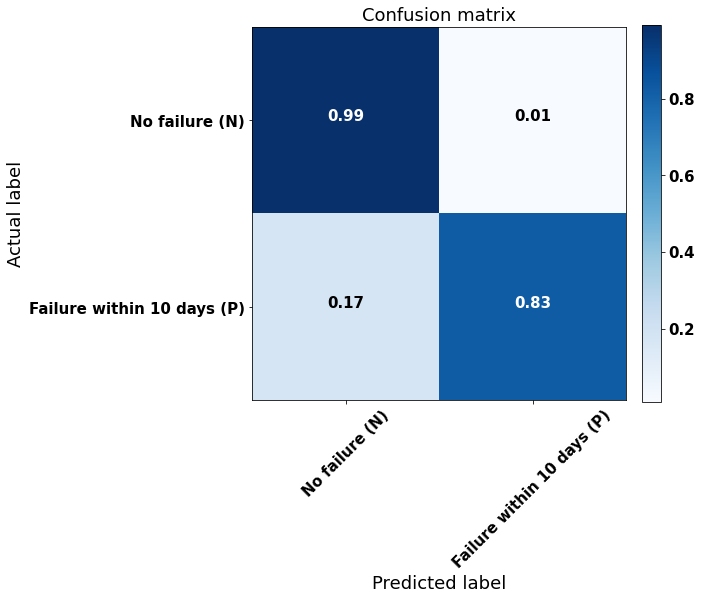

In [106]:
from storpdm.visualize import plot_confusion_matrix
confusionMatrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(confusionMatrix, normalize = True, classes=["No failure (N)","Failure within 10 days (P)"])

Normalized confusion matrix
[[0.99077869 0.00922131]
 [0.17488789 0.82511211]]


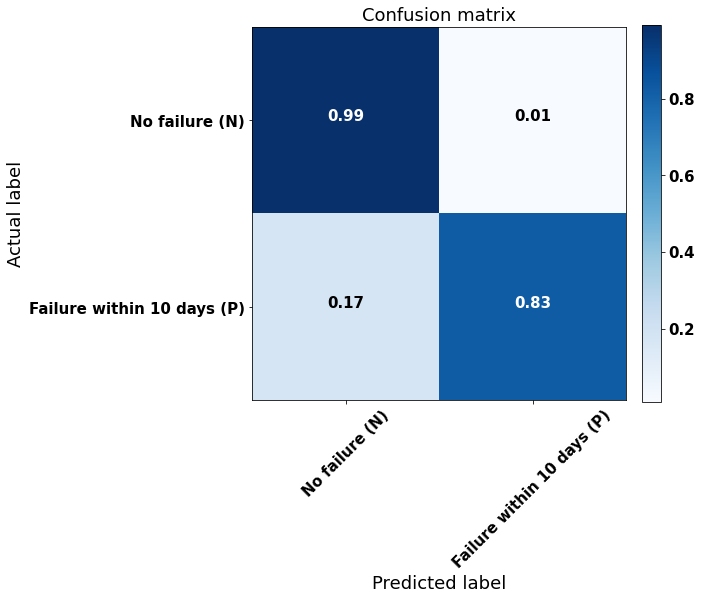

In [104]:
plot_confusion_matrix(confusionMatrix, normalize = True, classes=["No failure (N)","Failure within 10 days (P)"])

In [102]:
184/(184+36)

0.8363636363636363

# 